In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib

from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import PredefinedSplit
import scipy.stats as stats

In [2]:
# # CREATE A SPLITTER THAT DIVIDES DATA INTO THE TOP 10% AND THEN THE REST
# 
# def tts_strat_cont_top10(X, y, train_size, val_size, test_size, random_state):
#     # Compute the 90th percentile
#     top_10_percentile = y.quantile(0.9)
# 
#     # Create a new column that assigns a label to the bins (top 10% vs. rest)
#     y_bin = pd.cut(y, bins=[-float('inf'), top_10_percentile, float('inf')], # all values up to 90th, then all values after 90th
#                    labels=['rest', 'top_10'], include_lowest=True)
# 
#     # First split: stratify on the bin (top 10% vs. rest)
#     X_train, X_other, y_train, y_other = train_test_split(
#         X, y, train_size=train_size, stratify=y_bin, random_state=random_state)
# 
#     # Scale the validation size to reflect the remaining data
#     val_size_scaled = val_size / (val_size + test_size)
# 
#     # Create stratified bins for the second split
#     y_bin_other = pd.cut(y_other, bins=[-float('inf'), top_10_percentile, float('inf')],
#                          labels=['rest', 'top_10'], include_lowest=True)
#     
#     # Second split: stratify on the bin (top 10% vs. rest)
#     X_val, X_test, y_val, y_test = train_test_split(
#         X_other, y_other, train_size=val_size_scaled, stratify=y_bin_other, random_state=random_state)
# 
#     # Get the indices of each split for later use
#     train_indices = X_train.index
#     val_indices = X_val.index
#     test_indices = X_test.index
#     
#     return X_train, y_train, X_val, y_val, X_test, y_test, train_indices, val_indices, test_indices

In [2]:
# BUILD MODEL PIPELINE

# Lists to store results for multiple models
all_test_scores = {}
all_best_models = {}
all_best_r2 = {}


# function for the ML pipeline
# , train_size, val_size, test_size
def MLpipe_Strat_RMSE(X, y, preprocessor, ML_algo, param_grid, random_states):
    
    best_models = []
    test_scores = []
    r2_scores = []
    preprocessors = []
    
    for i in range(random_states):
        
        try:
            ML_algo_instance = ML_algo(random_state=i)
        except TypeError:
            ML_algo_instance = ML_algo

        if 'max_iter' in ML_algo_instance.get_params():
            try:
                ML_algo.set_params(max_iter=1000000)
            except (TypeError, ValueError):
                pass

        # # call my split function
        # X_train, y_train, X_val, y_val, X_test, y_test, train_indices, val_indices, test_indices = tts_strat_cont_top10(X, y, train_size, val_size, test_size, random_state=i)

        q = 10
        skf_test = StratifiedKFold(n_splits=5, shuffle=True, random_state=i).split(X, pd.qcut(y, q=q).cat.codes)
        train_index, test_index = list(skf_test)[0] # taking the first iteration of the 5 folds 
        X_train, y_train = X.iloc[train_index], y.iloc[train_index] # train is train + val
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]

        bins = np.linspace(0, 40, 21)
        plt.hist(y_train, alpha=0.5, bins=bins, density=True)
        plt.hist(y_test, alpha=0.5, bins=bins, density=True)
        plt.show()
        
        skf_val = StratifiedKFold(n_splits=5, shuffle=True, random_state=i).split(X_train, pd.qcut(y_train, q=q).cat.codes)
        
        # preprocess the sets and fit model with inputs
        pipe = make_pipeline(preprocessor, ML_algo)

        # cv=[(np.arange(len(X_train)), np.arange(len(X_val)))],  
        # search over specified parameter values
        grid = GridSearchCV(pipe, param_grid=param_grid, scoring='neg_root_mean_squared_error', 
                            return_train_score=True, n_jobs=-1, cv=skf_val,  
                            verbose=True)
        
        grid.fit(X_train, y_train)
       
        num_pipeline = grid.best_estimator_.named_steps['columntransformer'].named_transformers_['num_pipeline']
        preprocess_poly = num_pipeline.named_steps['poly_features']
        preprocess_scaler = num_pipeline.named_steps['scaler']
        preprocessors.append((preprocess_poly, preprocess_scaler))
        
        # access results and save them into a data frame
        results = pd.DataFrame(grid.cv_results_)
        #print(results)
        # access best models and save them
        best_models.append(grid.best_estimator_)
        print('best model parameters:',grid.best_params_)
        print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
        y_test_pred = grid.predict(X_test)
        test_scores.append(np.sqrt(mean_squared_error(y_test,y_test_pred)))
        r2_scores.append(r2_score(y_test,y_test_pred))
         #print("")
   
    return test_scores, best_models, r2_scores, preprocessors, X_test, y_test, y_train, y_test_pred, results #, y_val


In [3]:
df = pd.read_csv("interp_data/interp2.csv")
df = df.drop(df.columns[0], axis=1)

X = df[['no_wrk_aux','no2_wrk_aux','o3_wrk_aux','temp','rh','t_since_depl']] #,'rand'
y = df['no2_ref']

train_size = 0.6
val_size = 0.2
test_size = 0.2
random_states = 5

# preprocessor will be applied to all columns
num_cols = X.columns

# collect all the encoders into one preprocessor (eliminated imputer!)
num_pipeline= Pipeline([('poly_features', PolynomialFeatures(degree=6, include_bias=False, interaction_only=True)),
                        ('scaler', StandardScaler())])

preprocessor = ColumnTransformer([("num_pipeline", num_pipeline, num_cols)])

In [4]:
# Calculate baseline RMSE and R2 across random states
baseline_rmse = []
baseline_r2 = []
random_states = 5

for i in range(random_states):
            # call my split function
        #X_train, y_train, X_val, y_val, X_test, y_test, train_indices, val_indices, test_indices = tts_strat_cont_top10(
        #    X, y, train_size, val_size, test_size, random_state=i)

        q = 10
        skf_test = StratifiedKFold(n_splits=5, shuffle=True, random_state=i).split(X, pd.qcut(y, q=q).cat.codes)
        train_index, test_index = list(skf_test)[0] # taking the first iteration of the 5 folds 
        X_train, y_train = X.iloc[train_index], y.iloc[train_index] # train is train + val
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]


        # Calculate baseline scores
        y_mean = np.mean(y_test)
        baseline_array = np.full_like(y_test, y_mean)
        baseline_rmse.append(np.sqrt(mean_squared_error(y_test,baseline_array)))
        baseline_r2.append(r2_score(y_test,baseline_array))
        
print("Average baseline RMSE:", np.mean(baseline_rmse, axis = 0))
print("Average baseline R^2:", np.mean(baseline_r2, axis = 0))


Average baseline RMSE: 6.106888242072098
Average baseline R^2: 0.0


In [5]:
# Running splitters independently to see if it aligns with output

def basic_split(X,y,train_size,val_size,test_size,random_state):

    if train_size + val_size + test_size == 1.0 and isinstance(random_state, int):
        
        # First split to separate out the training set
        X_train, X_other, y_train, y_other = train_test_split(X,y,
                    train_size = train_size,random_state = random_state) 

        val_size_scaled = val_size/(val_size + test_size) # scale the val_size to reflect new fraction to select from
        
        # Second split to separate out the validation and test sets
        X_val, X_test, y_val, y_test = train_test_split(X_other,y_other, # now take the x_other and y_other from before, and split into the test and validation sets 
                    train_size = val_size_scaled,random_state = random_state)

        return (X_train, y_train, X_val, y_val, X_test, y_test)

    else:
        print("Error: Input splits do not add up to equal 1 or random_state is not an integer")

skf_skew = []
bs_skew = []
random_states = 30
import scipy.stats as stats

for i in range(random_states):

    # stratified kfold splitter
    q = 10
    skf_test = StratifiedKFold(n_splits=5, shuffle=True, random_state=i).split(X, pd.qcut(y, q=q).cat.codes)
    train_index, test_index = list(skf_test)[0] # taking the first iteration of the 5 folds 
    X_train_s, y_train_s = X.iloc[train_index], y.iloc[train_index] # train is train + val
    X_test_s, y_test_s = X.iloc[test_index], y.iloc[test_index]

    # basic split
    X_train_bs, y_train_bs, X_val_bs, y_val_bs, X_test_bs, y_test_bs = basic_split(
        X, y, train_size=train_size, val_size = val_size, test_size = test_size, random_state=i)

    skf_skew.append(y_test_s.skew())
    bs_skew.append(y_test_bs.skew())


print("Mean skewness of y_test_s:", np.mean(skf_skew))
print("Stdev skewness of y_test_s:", np.std(skf_skew))
print("")
print("Mean skewness of y_test_bs:", np.mean(bs_skew))
print("Stdev skewness of y_test_bs:", np.std(bs_skew))


Mean skewness of y_test_s: 2.1756095433659364
Stdev skewness of y_test_s: 0.05550261635987884

Mean skewness of y_test_bs: 2.1671669543723824
Stdev skewness of y_test_bs: 0.0636316559914177


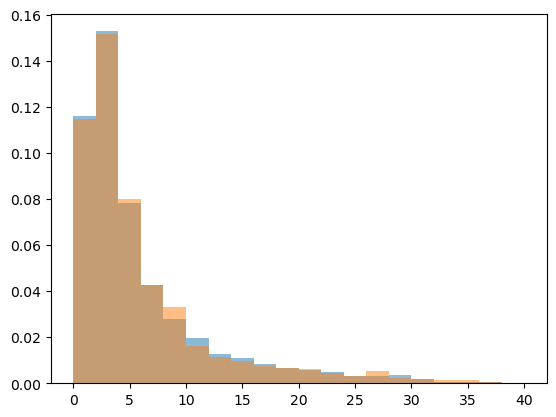

Fitting 5 folds for each of 1 candidates, totalling 5 fits
best model parameters: {'linearregression__fit_intercept': True}
validation score: -2.0967326937493236


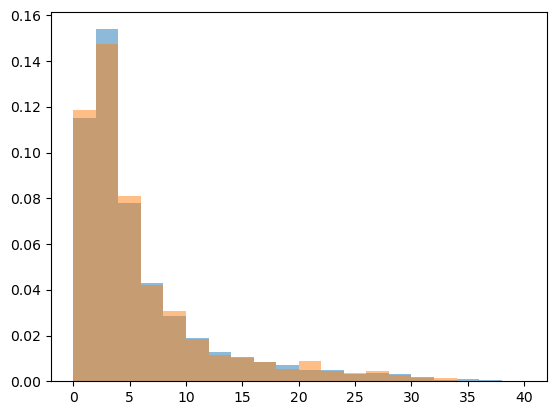

Fitting 5 folds for each of 1 candidates, totalling 5 fits
best model parameters: {'linearregression__fit_intercept': True}
validation score: -2.1121803948454834


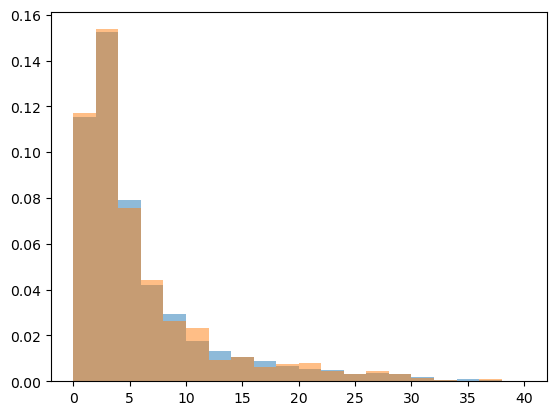

Fitting 5 folds for each of 1 candidates, totalling 5 fits
best model parameters: {'linearregression__fit_intercept': True}
validation score: -2.0959308328383788


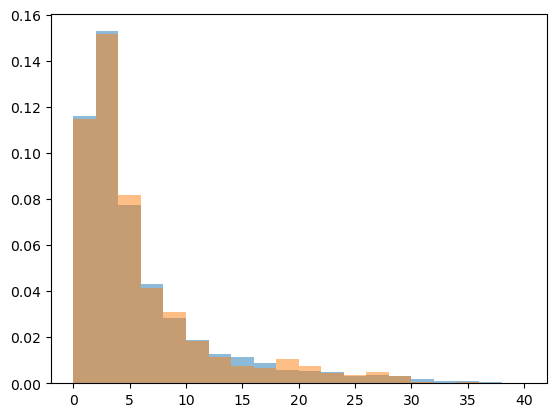

Fitting 5 folds for each of 1 candidates, totalling 5 fits
best model parameters: {'linearregression__fit_intercept': True}
validation score: -2.1099257821330353


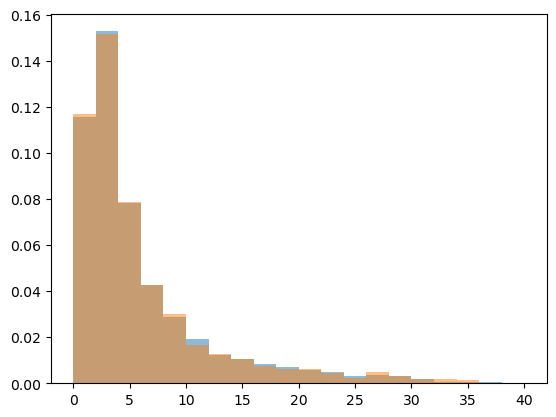

Fitting 5 folds for each of 1 candidates, totalling 5 fits
best model parameters: {'linearregression__fit_intercept': True}
validation score: -2.0582848519244594

Model: Linear Regression
Mean of test scores: 1.9898506356358325
Standard deviation of test scores: 0.05115059198722755
Mean of test R2 values: 0.8936864112064077
Standard deviation of test R2 values: 0.0061384500332916465


In [6]:
# LINEAR REGRESSION WITH NO REGULARIZATION

# hyperparameters to tune
param_grid_lr = {
    'linearregression__fit_intercept': [True]} 

# the model
ML_algo_lr = LinearRegression() 

# Execute the pipeline
# , y_val_lr
test_scores_lr, best_models_lr, r2_scores_lr, preprocessors_lr, X_test_lr, y_test_lr, y_train_lr, y_test_pred_lr, results_lr = MLpipe_Strat_RMSE(
    X, y, # train_size=0.6, val_size=0.2, test_size=0.2, 
    preprocessor=preprocessor, ML_algo=ML_algo_lr, param_grid=param_grid_lr, random_states=5
)

all_test_scores['Linear Regression'] = test_scores_lr
all_best_models['Linear Regression'] = best_models_lr
all_best_r2['Linear Regression'] = r2_scores_lr


print("")
print("Model: Linear Regression")
print("Mean of test scores:", np.mean(test_scores_lr))
print("Standard deviation of test scores:", np.std(test_scores_lr))
print("Mean of test R2 values:",np.mean(r2_scores_lr))
print("Standard deviation of test R2 values:",np.std(r2_scores_lr))


In [7]:
# EXTRACT THE TEST SETS AND MAKE SURE EVERYTHING LOOKS GOOD

# Extract the best pipeline from GridSearchCV
best_pipeline = best_models_lr[3]  # Use the first best model (or the desired one)

# Access the ColumnTransformer
column_transformer = best_pipeline.named_steps['columntransformer']

# Extract the numeric pipeline from the ColumnTransformer
num_pipeline = column_transformer.named_transformers_['num_pipeline']

# Extract specific preprocessors
preprocess_poly = num_pipeline.named_steps['poly_features']
preprocess_scaler = num_pipeline.named_steps['scaler']

# Step 1: Apply PolynomialFeatures
X_test_poly = preprocess_poly.transform(X_test_lr)

# Step 2: Apply StandardScaler to the transformed data
X_test_poly_scaled = preprocess_scaler.transform(X_test_poly)

# Inspect results
print("Shape after PolynomialFeatures:", X_test_poly.shape)
print("Shape after StandardScaler:", X_test_poly_scaled.shape)

print("y_train skewness:",stats.skew(y_train_lr))
print("y_test skewness:",stats.skew(y_test_lr))

# Access column names
feature_names = preprocess_poly.get_feature_names_out(input_features=X.columns)


Shape after PolynomialFeatures: (1637, 63)
Shape after StandardScaler: (1637, 63)
y_train skewness: 2.162910335827434
y_test skewness: 2.209019074874324


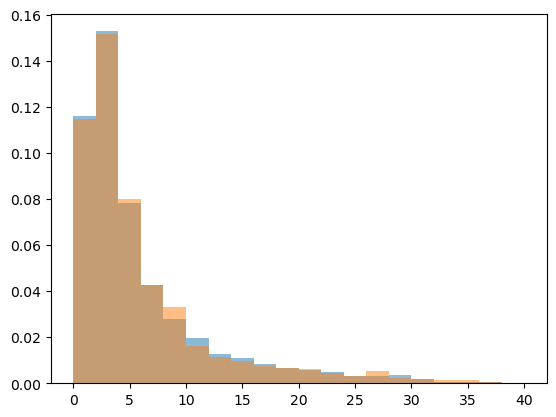

Fitting 5 folds for each of 3 candidates, totalling 15 fits
best model parameters: {'ridge__alpha': 1e-05}
validation score: -2.096716214981067


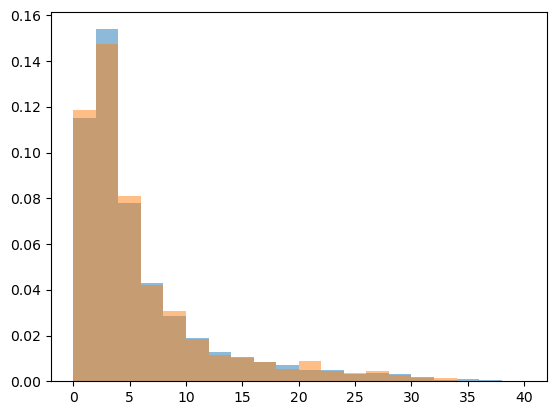

Fitting 5 folds for each of 3 candidates, totalling 15 fits
best model parameters: {'ridge__alpha': 1e-05}
validation score: -2.112236804663946


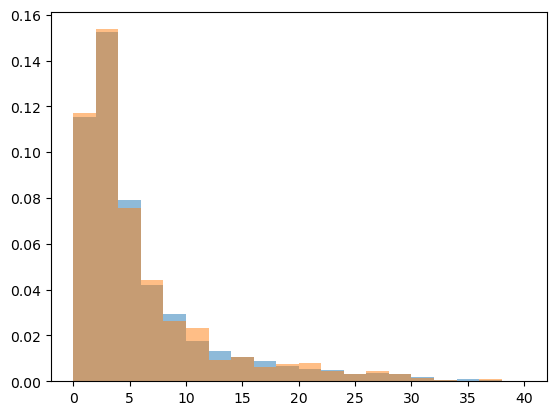

Fitting 5 folds for each of 3 candidates, totalling 15 fits
best model parameters: {'ridge__alpha': 0.001}
validation score: -2.081971723031937


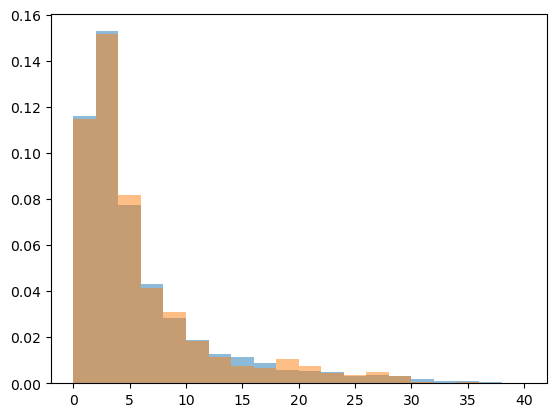

Fitting 5 folds for each of 3 candidates, totalling 15 fits
best model parameters: {'ridge__alpha': 0.0001}
validation score: -2.1089756808361155


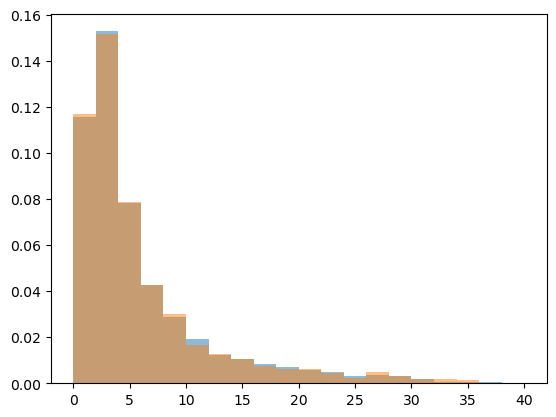

Fitting 5 folds for each of 3 candidates, totalling 15 fits
best model parameters: {'ridge__alpha': 0.0001}
validation score: -2.0576538239987725

Model: Ridge Regression
Mean of test scores: 1.9878484179409868
Standard deviation of test scores: 0.0513963480115381
Mean of test R2 values: 0.8939031561908214
Standard deviation of test R2 values: 0.006098518570137934


In [8]:
# RIDGE

# hyperparameters to tune
param_grid_rdg = {
    'ridge__alpha': [0.00001,0.0001,0.001]} 

# the model
ML_algo_rdg = Ridge() 

# Execute the pipeline
test_scores_rdg, best_models_rdg, r2_scores_rdg, preprocessors_rdg, X_test_rdg, y_test_rdg, y_train_rdg, y_test_pred_rdg, results_rdg = MLpipe_Strat_RMSE(
    X, y, #train_size=0.6, val_size=0.2, test_size=0.2, 
    preprocessor=preprocessor, ML_algo=ML_algo_rdg, param_grid=param_grid_rdg, random_states=5
)#y_val_rdg,

all_test_scores['Ridge Regression'] = test_scores_rdg
all_best_models['Ridge Regression'] = best_models_rdg
all_best_r2['Ridge Regression'] = r2_scores_rdg

print("")
print("Model: Ridge Regression")
print("Mean of test scores:", np.mean(test_scores_rdg))
print("Standard deviation of test scores:", np.std(test_scores_rdg))
print("Mean of test R2 values:",np.mean(r2_scores_rdg))
print("Standard deviation of test R2 values:",np.std(r2_scores_rdg))


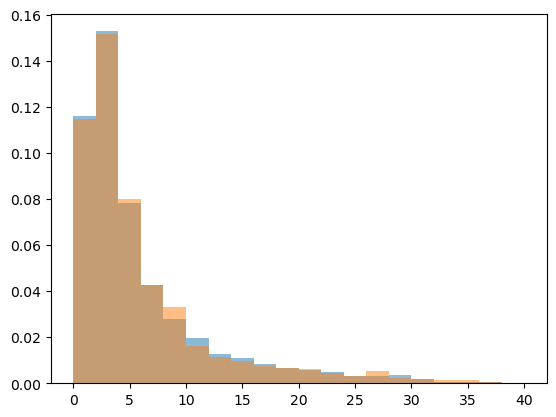

Fitting 5 folds for each of 2 candidates, totalling 10 fits
best model parameters: {'lasso__alpha': 0.001}
validation score: -2.182350711223664


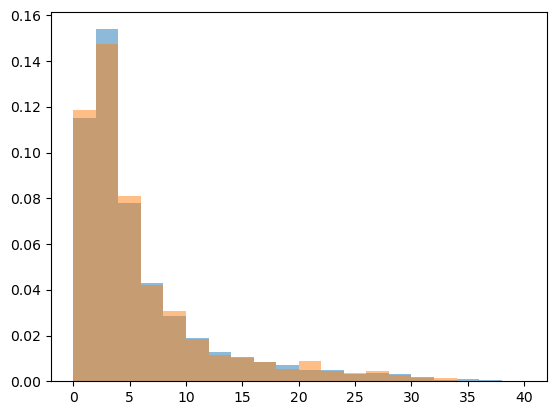

Fitting 5 folds for each of 2 candidates, totalling 10 fits
best model parameters: {'lasso__alpha': 0.001}
validation score: -2.2141164293546134


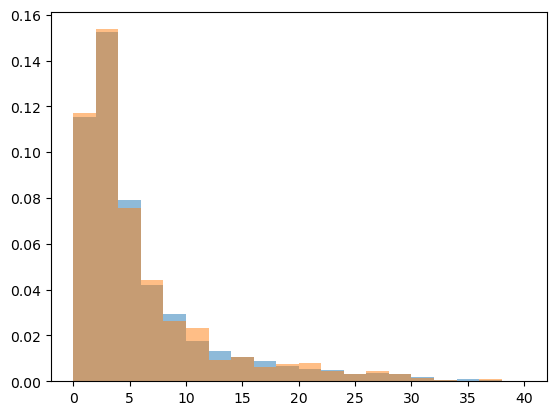

Fitting 5 folds for each of 2 candidates, totalling 10 fits
best model parameters: {'lasso__alpha': 0.001}
validation score: -2.189829577812468


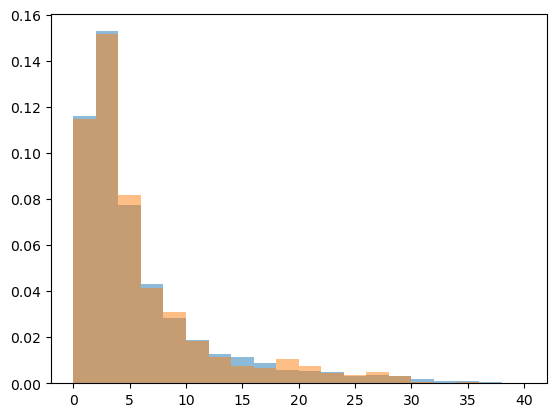

Fitting 5 folds for each of 2 candidates, totalling 10 fits
best model parameters: {'lasso__alpha': 0.001}
validation score: -2.1976679718768968


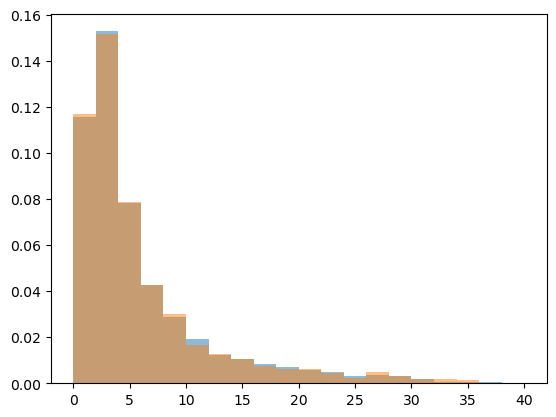

Fitting 5 folds for each of 2 candidates, totalling 10 fits
best model parameters: {'lasso__alpha': 0.001}
validation score: -2.146382165262655

Model: Lasso Regression
Mean of test scores: 2.1094932222147684
Standard deviation of test scores: 0.05268451817261829
Mean of test R2 values: 0.8805895249844868
Standard deviation of test R2 values: 0.0055411481996834756


In [18]:
# LASSO 

# hyperparameters to tune
param_grid_lss = {
    'lasso__alpha': [0.001, 0.01]} 

# the model
ML_algo_lss = Lasso() 

# Execute the pipeline
test_scores_lss, best_models_lss, r2_scores_lss, preprocessors_lss, X_test_lss, y_test_lss, y_train_lss, y_test_pred_lss, results_lss = MLpipe_Strat_RMSE(
    X, y, #train_size=0.6, val_size=0.2, test_size=0.2, 
    preprocessor=preprocessor, ML_algo=ML_algo_lss, param_grid=param_grid_lss, random_states=5
) # y_val_lss,

all_test_scores['Lasso Regression'] = test_scores_lss
all_best_models['Lasso Regression'] = best_models_lss
all_best_r2['Lasso Regression'] = r2_scores_lss

print("")
print("Model: Lasso Regression")
print("Mean of test scores:", np.mean(test_scores_lss))
print("Standard deviation of test scores:", np.std(test_scores_lss))
print("Mean of test R2 values:",np.mean(r2_scores_lss))
print("Standard deviation of test R2 values:",np.std(r2_scores_lss))


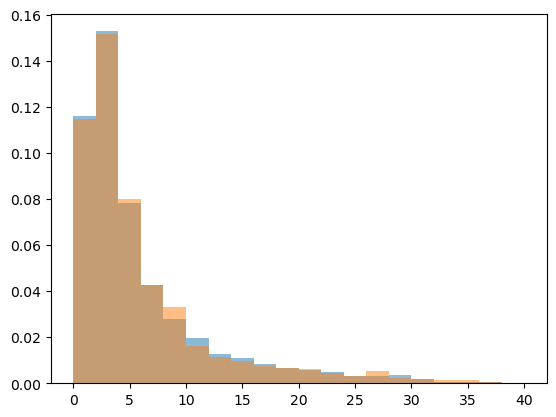

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


best model parameters: {'randomforestregressor__max_depth': 15, 'randomforestregressor__n_estimators': 200}
validation score: -1.5907490315339678


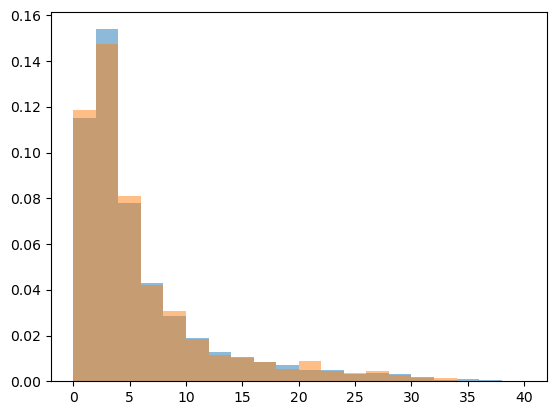

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


best model parameters: {'randomforestregressor__max_depth': 15, 'randomforestregressor__n_estimators': 200}
validation score: -1.5954277365451133


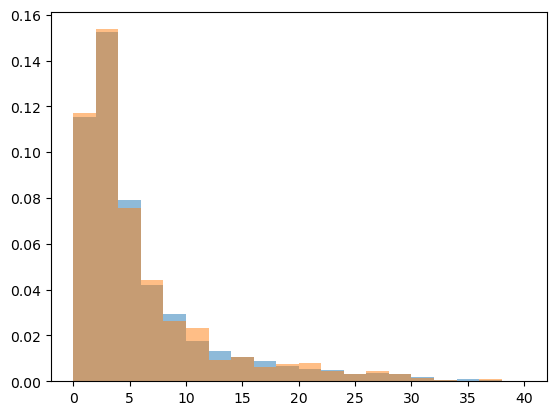

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


best model parameters: {'randomforestregressor__max_depth': 15, 'randomforestregressor__n_estimators': 100}
validation score: -1.5914414637047916


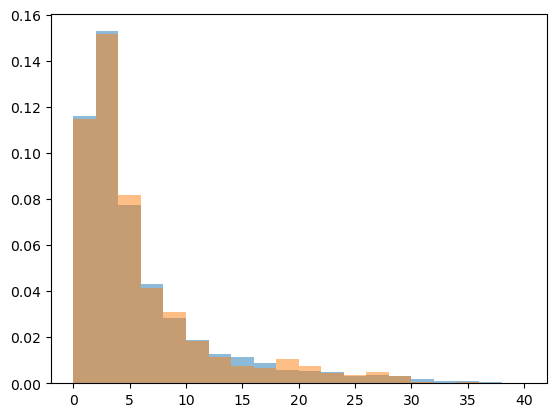

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


best model parameters: {'randomforestregressor__max_depth': 15, 'randomforestregressor__n_estimators': 200}
validation score: -1.5876770892643075


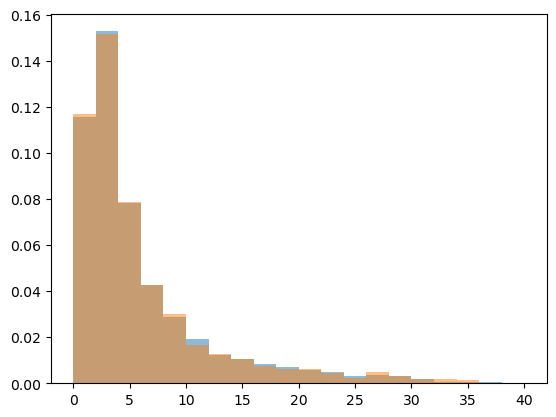

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


best model parameters: {'randomforestregressor__max_depth': 15, 'randomforestregressor__n_estimators': 200}
validation score: -1.5765490027249445

Model: Random Forest
Mean of test scores: 1.4681881273075745
Standard deviation of test scores: 0.04322052116002929
Mean of test R2 values: 0.9421079560376983
Standard deviation of test R2 values: 0.00377294596831699


In [10]:
# RANDOM FOREST - CHANGE PARAMETER GRID!

from sklearn.ensemble import RandomForestRegressor

# parameter grid
param_grid_rf = {
    'randomforestregressor__n_estimators': [100, 200],
    'randomforestregressor__max_depth': [15]} 

# model
ML_algo_rf = RandomForestRegressor()

# Execute the pipeline
test_scores_rf, best_models_rf, r2_scores_rf, preprocessors_rf, X_test_rf, y_test_rf, y_train_rf, y_test_pred_rf, results_rf  = MLpipe_Strat_RMSE(
    X, y, #train_size=0.6, val_size=0.2, test_size=0.2, 
    preprocessor=preprocessor, ML_algo=ML_algo_rf, param_grid=param_grid_rf, random_states=5
)

all_test_scores['Random Forest'] = test_scores_rf
all_best_models['Random Forest'] = best_models_rf
all_best_r2['Random Forest'] = r2_scores_rf

print("")
print("Model: Random Forest")
print("Mean of test scores:", np.mean(test_scores_rf))
print("Standard deviation of test scores:", np.std(test_scores_rf))
print("Mean of test R2 values:",np.mean(r2_scores_rf))
print("Standard deviation of test R2 values:",np.std(r2_scores_rf))

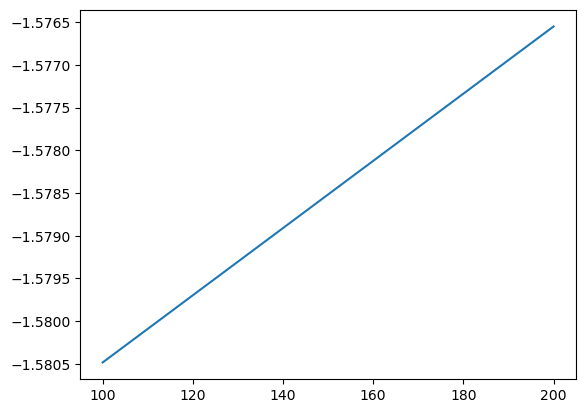

In [32]:
plt.plot(param_grid_rf['randomforestregressor__n_estimators'], results_rf['mean_test_score'])

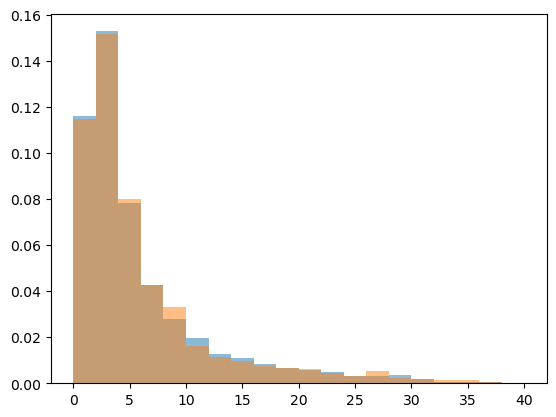

Fitting 5 folds for each of 1 candidates, totalling 5 fits
best model parameters: {'xgbregressor__learning_rate': 0.3, 'xgbregressor__max_depth': 4, 'xgbregressor__n_estimators': 500}
validation score: -1.4041350770548544


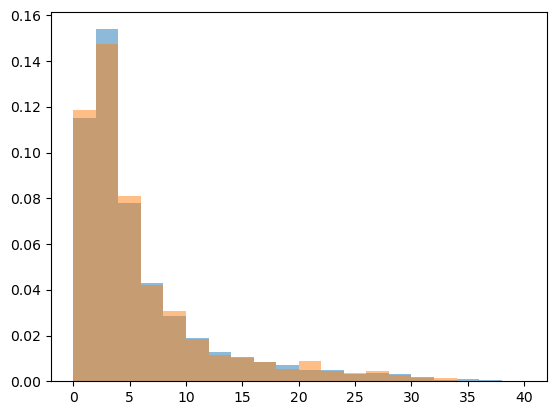

Fitting 5 folds for each of 1 candidates, totalling 5 fits
best model parameters: {'xgbregressor__learning_rate': 0.3, 'xgbregressor__max_depth': 4, 'xgbregressor__n_estimators': 500}
validation score: -1.389731987534652


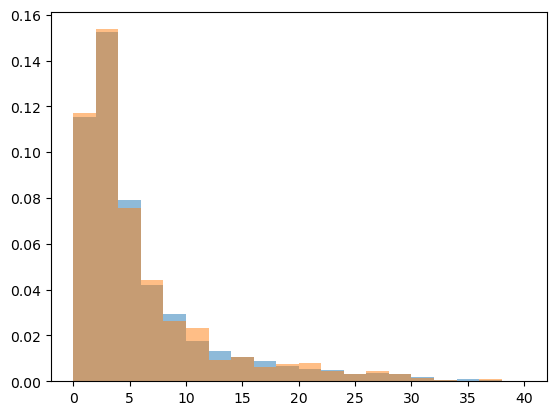

Fitting 5 folds for each of 1 candidates, totalling 5 fits
best model parameters: {'xgbregressor__learning_rate': 0.3, 'xgbregressor__max_depth': 4, 'xgbregressor__n_estimators': 500}
validation score: -1.376897183618725


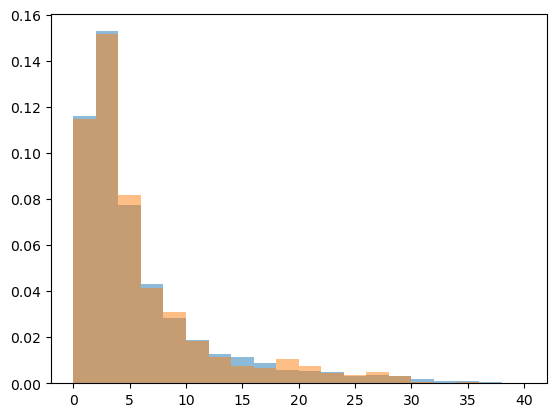

Fitting 5 folds for each of 1 candidates, totalling 5 fits
best model parameters: {'xgbregressor__learning_rate': 0.3, 'xgbregressor__max_depth': 4, 'xgbregressor__n_estimators': 500}
validation score: -1.4110750973100559


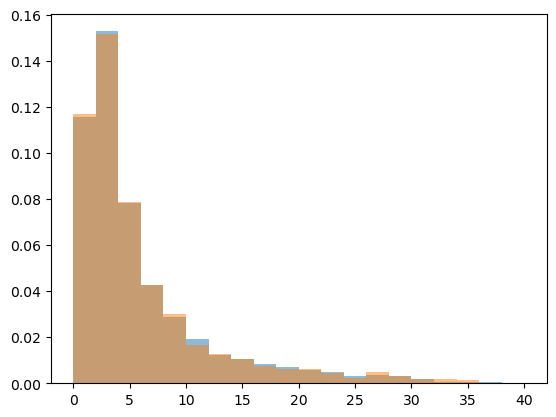

Fitting 5 folds for each of 1 candidates, totalling 5 fits
best model parameters: {'xgbregressor__learning_rate': 0.3, 'xgbregressor__max_depth': 4, 'xgbregressor__n_estimators': 500}
validation score: -1.3947540044743651

Model: XGBoost
Mean of test scores: 1.245402112636449
Standard deviation of test scores: 0.01645599549738111
Mean of test R2 values: 0.9583661027103902
Standard deviation of test R2 values: 0.0018008976635635408


In [12]:
# XGBoost
import xgboost

# parameter grid
param_grid_xgb = {
    "xgbregressor__learning_rate": [0.3],  # low learning rate is good for smaller data set
    "xgbregressor__max_depth": [4],
    "xgbregressor__n_estimators": [500]
}

# model
ML_algo_xgb = xgboost.XGBRegressor()

# Execute the pipeline
test_scores_xgb, best_models_xgb, r2_scores_xgb, preprocessors_xgb, X_test_xgb, y_test_xgb, y_train_xgb, y_test_pred_xgb, results_xgb = MLpipe_Strat_RMSE(
    X, y, #train_size=0.6, val_size=0.2, test_size=0.2, 
    preprocessor=preprocessor, ML_algo=ML_algo_xgb, param_grid=param_grid_xgb, random_states=5
)#y_val_xgb,

all_test_scores['XGBoost'] = test_scores_xgb
all_best_models['XGBoost'] = best_models_xgb
all_best_r2['XGBoost'] = r2_scores_xgb

print("")
print("Model: XGBoost")
print("Mean of test scores:", np.mean(test_scores_xgb))
print("Standard deviation of test scores:", np.std(test_scores_xgb))
print("Mean of test R2 values:",np.mean(r2_scores_xgb))
print("Standard deviation of test R2 values:",np.std(r2_scores_xgb))

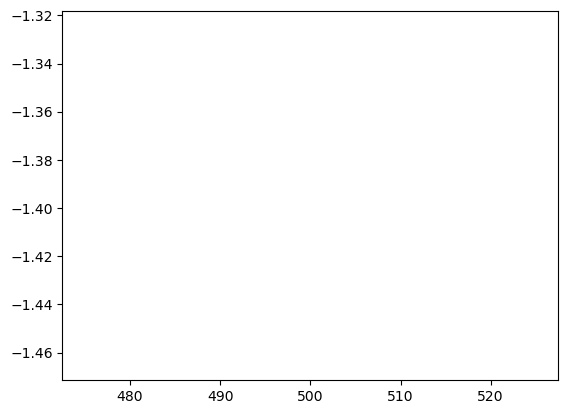

In [31]:
plt.plot(param_grid_xgb['xgbregressor__n_estimators'], results_xgb['mean_test_score'])

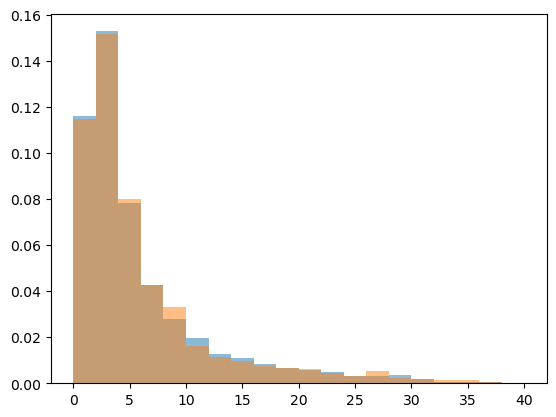

Fitting 5 folds for each of 6 candidates, totalling 30 fits
best model parameters: {'kneighborsregressor__n_neighbors': 3, 'kneighborsregressor__weights': 'distance'}
validation score: -2.0882436973923246


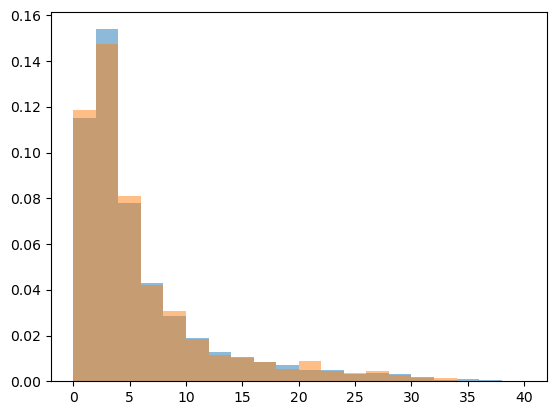

Fitting 5 folds for each of 6 candidates, totalling 30 fits
best model parameters: {'kneighborsregressor__n_neighbors': 3, 'kneighborsregressor__weights': 'distance'}
validation score: -2.0770209902656744


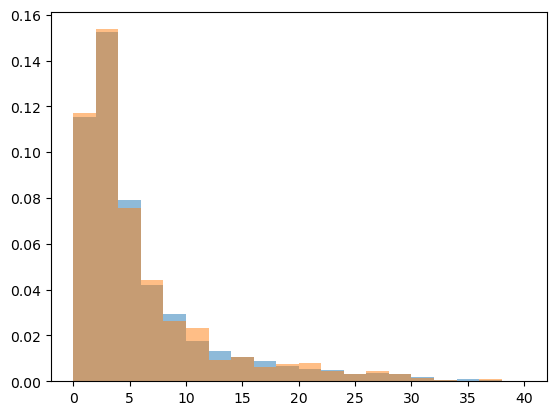

Fitting 5 folds for each of 6 candidates, totalling 30 fits
best model parameters: {'kneighborsregressor__n_neighbors': 3, 'kneighborsregressor__weights': 'distance'}
validation score: -2.0472143659256146


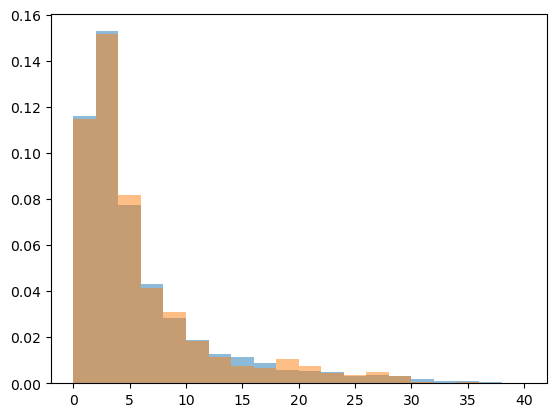

Fitting 5 folds for each of 6 candidates, totalling 30 fits
best model parameters: {'kneighborsregressor__n_neighbors': 3, 'kneighborsregressor__weights': 'distance'}
validation score: -2.0873990100599307


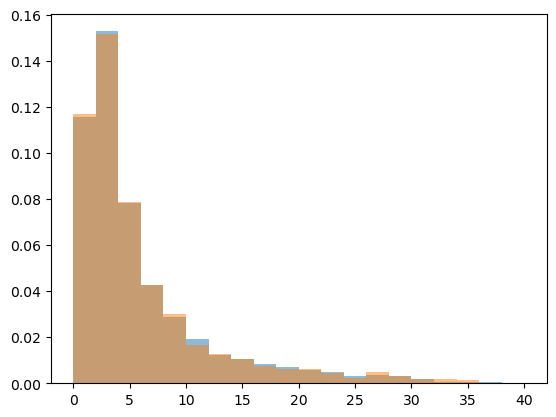

Fitting 5 folds for each of 6 candidates, totalling 30 fits
best model parameters: {'kneighborsregressor__n_neighbors': 3, 'kneighborsregressor__weights': 'distance'}
validation score: -2.1398719728871485

Model: Nearest Neighbors
Mean of test scores: 1.9573103244349337
Standard deviation of test scores: 0.025329984418382964
Mean of test R2 values: 0.897202700249005
Standard deviation of test R2 values: 0.003461819016399026


In [13]:
# NEAREST NEIGHBOR
from sklearn.neighbors import KNeighborsRegressor

# parameter grid
param_grid_knn = {
    'kneighborsregressor__n_neighbors': [2, 3, 4],
    'kneighborsregressor__weights': ["distance", "uniform"]} 

# model
ML_algo_knn = KNeighborsRegressor() # no random state

# Execute the pipeline
test_scores_knn, best_models_knn, r2_scores_knn, preprocessors_knn, X_test_knn, y_test_knn, y_train_knn, y_test_pred_knn, results_knn = MLpipe_Strat_RMSE(
    X, y, #train_size=0.6, val_size=0.2, test_size=0.2, 
    preprocessor=preprocessor, ML_algo=ML_algo_knn, param_grid=param_grid_knn, random_states=5
) # y_val_knn,

all_test_scores['Nearest Neighbors'] = test_scores_knn
all_best_models['Nearest Neighbors'] = best_models_knn
all_best_r2['Nearest Neighbors'] = r2_scores_knn

print("")
print("Model: Nearest Neighbors")
print("Mean of test scores:", np.mean(test_scores_knn))
print("Standard deviation of test scores:", np.std(test_scores_knn))
print("Mean of test R2 values:",np.mean(r2_scores_knn))
print("Standard deviation of test R2 values:",np.std(r2_scores_knn))

In [14]:
####################################################################
# FEATURE IMPORTANCES
# Calculate at least three different global feature importances and discuss your findings. 
# Also calculate SHAP values for local feature importance.

# Access column names
feature_names = preprocess_poly.get_feature_names_out(input_features=X.columns)


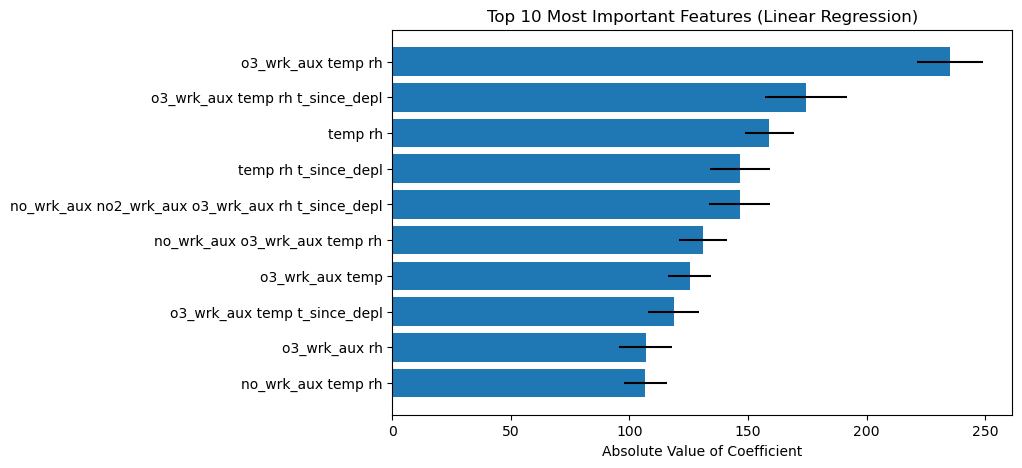

In [24]:
# Global feature importance for the linear regression (no regularization) - AKA just the coefficients

coefs_lr = []

for i in range(len(best_models_lr)):

    pipeline = best_models_lr[i]
    model = pipeline.named_steps['linearregression'] 
    coef_lr = model.coef_
    coefs_lr.append(coef_lr)

coefs_lr_array = np.array(coefs_lr)

avg_coefs_lr = np.mean(np.abs(coefs_lr_array), axis=0)
std_coefs_lr = np.std(np.abs(coefs_lr_array), axis=0)

label_avg_coefs_lr = pd.Series(avg_coefs_lr, index=feature_names)
label_std_coefs_lr = pd.Series(std_coefs_lr, index=feature_names)

sorted_idx_lr = label_avg_coefs_lr.sort_values(ascending=False).index[:10]
sorted_coefs_mean_lr = label_avg_coefs_lr.loc[sorted_idx_lr]
sorted_coefs_std_lr = label_std_coefs_lr.loc[sorted_idx_lr]

plt.figure(figsize=(8, 5))
plt.barh(sorted_coefs_mean_lr.index, sorted_coefs_mean_lr.values, xerr=sorted_coefs_std_lr.values)
plt.xlabel('Absolute Value of Coefficient')
plt.title('Top 10 Most Important Features (Linear Regression)')
plt.gca().invert_yaxis() 



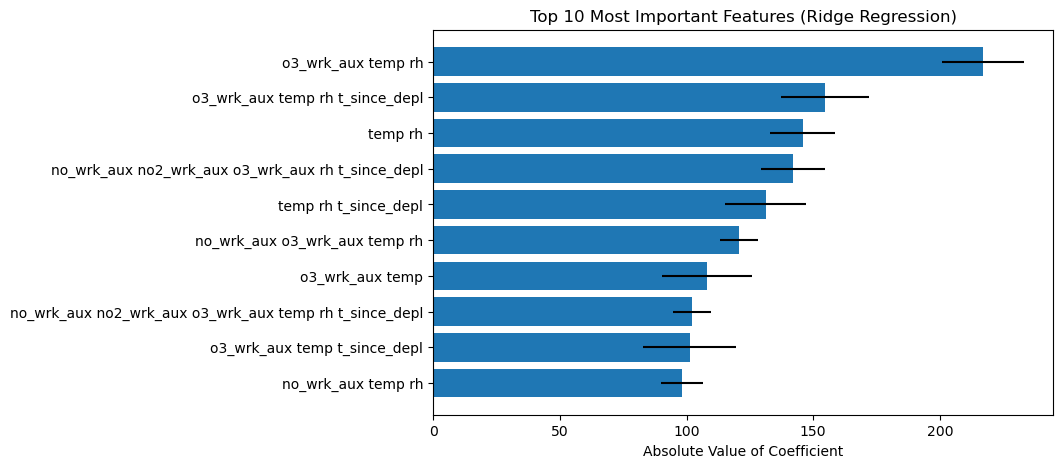

In [25]:
# Global feature importance for the ridge regression

coefs_rdg = []

for i in range(len(best_models_rdg)):

    pipeline = best_models_rdg[i]
    model = pipeline.named_steps['ridge'] 
    coef_rdg = model.coef_
    coefs_rdg.append(coef_rdg)

coefs_rdg_array = np.array(coefs_rdg)

avg_coefs_rdg = np.mean(np.abs(coefs_rdg_array), axis=0)
std_coefs_rdg = np.std(np.abs(coefs_rdg_array), axis=0)

label_avg_coefs_rdg = pd.Series(avg_coefs_rdg, index=feature_names)
label_std_coefs_rdg = pd.Series(std_coefs_rdg, index=feature_names)

sorted_idx_rdg = label_avg_coefs_rdg.sort_values(ascending=False).index[:10]
sorted_coefs_mean_rdg = label_avg_coefs_rdg.loc[sorted_idx_rdg]
sorted_coefs_std_rdg = label_std_coefs_rdg.loc[sorted_idx_rdg]

plt.figure(figsize=(8, 5))
plt.barh(sorted_coefs_mean_rdg.index, sorted_coefs_mean_rdg.values, xerr=sorted_coefs_std_rdg.values)
plt.xlabel('Absolute Value of Coefficient')
plt.title('Top 10 Most Important Features (Ridge Regression)')
plt.gca().invert_yaxis() 

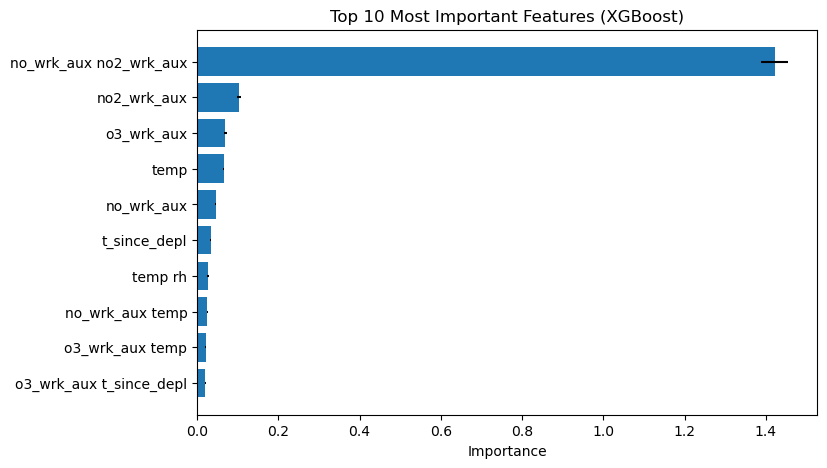

In [26]:
# Global and local feature importance for XGBoost

from sklearn.inspection import permutation_importance
import shap
shap.initjs() # required for visualizations

xgb_impt_results = []
X_test_poly_scaled_sets = []
explainers = []
shap_values_sets = []

for i in range(len(best_models_xgb)):

    # global importance with permutation_importance
    best_pipeline = best_models_xgb[i]
    model = best_pipeline.named_steps['xgbregressor'] 
    column_transformer = best_pipeline.named_steps['columntransformer']
    num_pipeline = column_transformer.named_transformers_['num_pipeline']
    preprocess_poly = num_pipeline.named_steps['poly_features']
    preprocess_scaler = num_pipeline.named_steps['scaler']

    X_test_poly = preprocess_poly.transform(X_test_xgb)
    X_test_poly_scaled = preprocess_scaler.transform(X_test_poly)
    X_test_poly_scaled_sets.append(X_test_poly_scaled)

    result = permutation_importance(model, X_test_poly_scaled, y_test_xgb, n_repeats=10, random_state=i)
    xgb_impt_results.append(result)

    # local importance with shap
    explainer = shap.TreeExplainer(model)
    explainers.append(explainer)
    shap_values = explainer.shap_values(X_test_poly_scaled) # on the preprocessed set
    shap_values_sets.append(shap_values)


importances_mean = np.mean([result['importances_mean'] for result in xgb_impt_results], axis=0)
importances_std = np.mean([result['importances_std'] for result in xgb_impt_results], axis=0)

label_importances_mean = pd.Series(importances_mean, index=feature_names)
label_importances_std = pd.Series(importances_std, index=feature_names)

sorted_idx = label_importances_mean.sort_values(ascending=False).index[:10]
sorted_importances_mean = label_importances_mean.loc[sorted_idx]
sorted_importances_std = label_importances_std.loc[sorted_idx]


# Global plot
plt.figure(figsize=(8, 5))
plt.barh(sorted_importances_mean.index, sorted_importances_mean.values, xerr=sorted_importances_std.values)
plt.xlabel('Importance')
plt.title('Top 10 Most Important Features (XGBoost)')
plt.gca().invert_yaxis() 


In [27]:
# Make local shap plots for the first three points in the first "best model"

shap_values_model_0 = shap_values_sets[0]

shap_values_model_0_idx_0 = shap_values_model_0[0,:]
shap_values_model_0_idx_1 = shap_values_model_0[1,:]
shap_values_model_0_idx_2 = shap_values_model_0[2,:]

# Get explainer and features for model 0
explainer_0 = explainers[0]
X_test_poly_scaled_0 = X_test_poly_scaled_sets[0]

# Transform test set into df
X_test_poly_scaled_0_df = pd.DataFrame(X_test_poly_scaled_0, columns=feature_names)

# Local plots
force_plot_0 = shap.force_plot(explainer_0.expected_value, shap_values_model_0_idx_0, features = X_test_poly_scaled_0_df.iloc[0,:,], feature_names = feature_names)
force_plot_1 = shap.force_plot(explainer_0.expected_value, shap_values_model_0_idx_1, features = X_test_poly_scaled_0_df.iloc[1,:], feature_names = feature_names)
force_plot_2 = shap.force_plot(explainer_0.expected_value, shap_values_model_0_idx_2, features = X_test_poly_scaled_0_df.iloc[2,:], feature_names = feature_names)

display(force_plot_0)
display(force_plot_1)
display(force_plot_2)


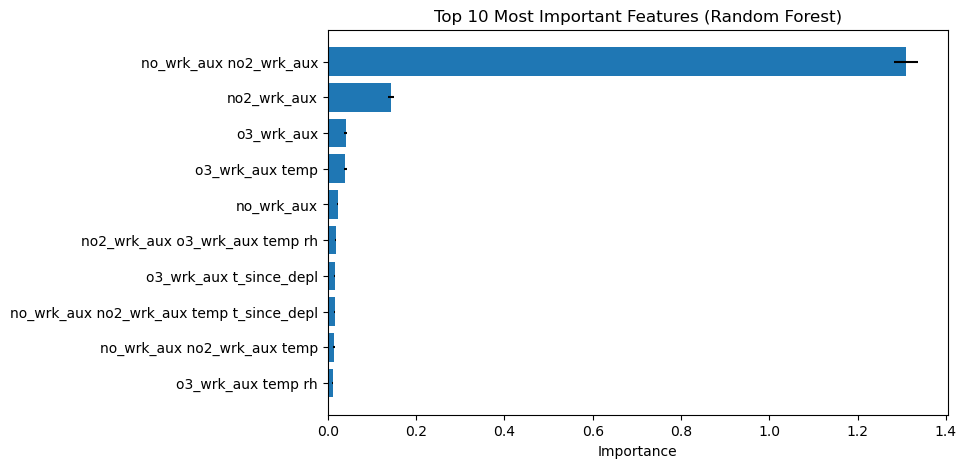

In [28]:
# Global feature importance for Random Forest

rf_impt_results = []
X_test_poly_scaled_sets = []
explainers = []
shap_values_sets = []

for i in range(len(best_models_rf)):

    pipeline = best_models_rf[i]
    model = pipeline.named_steps['randomforestregressor'] 
    column_transformer = best_pipeline.named_steps['columntransformer']
    num_pipeline = column_transformer.named_transformers_['num_pipeline']
    preprocess_poly = num_pipeline.named_steps['poly_features']
    preprocess_scaler = num_pipeline.named_steps['scaler']

    X_test_poly = preprocess_poly.transform(X_test_rf)
    X_test_poly_scaled = preprocess_scaler.transform(X_test_poly)
    X_test_poly_scaled_sets.append(X_test_poly_scaled)

    result = permutation_importance(model, X_test_poly_scaled, y_test_rf, n_repeats=10, random_state=i)
    rf_impt_results.append(result)

    # local importance with shap
    explainer = shap.TreeExplainer(model)
    explainers.append(explainer)
    shap_values = explainer.shap_values(X_test_poly_scaled) # on the preprocessed set
    shap_values_sets.append(shap_values)


importances_mean = np.mean([result['importances_mean'] for result in rf_impt_results], axis=0)
importances_std = np.mean([result['importances_std'] for result in rf_impt_results], axis=0)

label_importances_mean = pd.Series(importances_mean, index=feature_names)
label_importances_std = pd.Series(importances_std, index=feature_names)

sorted_idx = label_importances_mean.sort_values(ascending=False).index[:10]
sorted_importances_mean = label_importances_mean.loc[sorted_idx]
sorted_importances_std = label_importances_std.loc[sorted_idx]

plt.figure(figsize=(8, 5))
plt.barh(sorted_importances_mean.index, sorted_importances_mean.values, xerr=sorted_importances_std.values)
plt.xlabel('Importance')
plt.title('Top 10 Most Important Features (Random Forest)')
plt.gca().invert_yaxis() 


In [30]:
# Make local shap plots for the first three points in the first "best model"

shap_values_model_0 = shap_values_sets[0]

shap_values_model_0_idx_0 = shap_values_model_0[0,:]
shap_values_model_0_idx_1 = shap_values_model_0[1,:]
shap_values_model_0_idx_2 = shap_values_model_0[2,:]

# Get explainer and features for model 0
explainer_0 = explainers[0]
X_test_poly_scaled_0 = X_test_poly_scaled_sets[0]

# Transform test set into df
X_test_poly_scaled_0_df = pd.DataFrame(X_test_poly_scaled_0, columns=feature_names)

# Local plots
force_plot_0 = shap.force_plot(explainer_0.expected_value, shap_values_model_0_idx_0, features = X_test_poly_scaled_0_df.iloc[0,:,], feature_names = feature_names)
force_plot_1 = shap.force_plot(explainer_0.expected_value, shap_values_model_0_idx_1, features = X_test_poly_scaled_0_df.iloc[1,:], feature_names = feature_names)
force_plot_2 = shap.force_plot(explainer_0.expected_value, shap_values_model_0_idx_2, features = X_test_poly_scaled_0_df.iloc[2,:], feature_names = feature_names)

display(force_plot_0)
display(force_plot_1)
display(force_plot_2)

In [15]:
# EVALUATE MODEL PERFORMANCES UNDER HIGH TEMPERATURE CONDITIONS

# Linear regression (no regulatization)

# Check that lengths are all the same
print("Shape of X_test_lr:", X_test_lr.shape)
print("Shape of y_test_lr:", y_test_lr.shape)
print("Shape of y_test_pred_lr:", y_test_pred_lr.shape)

# Make y_pred into a df
y_test_pred_lr_df = pd.DataFrame(y_test_pred_lr, columns=['y_pred_lr'])

# Drop indices
X_test_lr = X_test_lr.reset_index(drop=True) # test sets still have old indices - need to reset
y_test_lr = y_test_lr.reset_index(drop=True)

# Concatenate sets
ys_lr_lrs = pd.merge(y_test_lr, y_test_pred_lr_df, left_index = True, right_index = True)
all_lr_lrs = pd.merge(X_test_lr,ys_lr_lrs, left_index = True, right_index = True)
#print(all_lr_lrs.shape)

# Isolate high temps
all_lr_lrs_high_t = all_lr_lrs[all_lr_lrs["temp"] > 30]
# print(all_lr_lrs_high_t)

# Calculate RMSE and R^2 for high t set
high_t_rmse_lr = np.sqrt(mean_squared_error(all_lr_lrs_high_t["no2_ref"],all_lr_lrs_high_t["y_pred_lr"]))
high_t_r2_lr = r2_score(all_lr_lrs_high_t["no2_ref"],all_lr_lrs_high_t["y_pred_lr"])

print("High temp RMSE:",high_t_rmse_lr)
print("High temp R^2:",high_t_r2_lr)

Shape of X_test_lr: (1637, 6)
Shape of y_test_lr: (1637,)
Shape of y_test_pred_lr: (1637,)
High temp RMSE: 2.1224624587209844
High temp R^2: -0.22959307560979814


In [16]:
# EVALUATE MODEL PERFORMANCES UNDER HIGH TEMPERATURE CONDITIONS

# Ridge regression

# Check that lengths are all the same
print("Shape of X_test_rdg:", X_test_rdg.shape)
print("Shape of y_test_rdg:", y_test_rdg.shape)
print("Shape of y_test_pred_rdg:", y_test_pred_rdg.shape)

# Make y_pred into a df
y_test_pred_rdg_df = pd.DataFrame(y_test_pred_rdg, columns=['y_pred_rdg'])

# Drop indices
X_test_rdg = X_test_rdg.reset_index(drop=True) # test sets still have old indices - need to reset
y_test_rdg = y_test_rdg.reset_index(drop=True)

# Concatenate sets
ys_rdg_lrs = pd.merge(y_test_rdg, y_test_pred_rdg_df, left_index = True, right_index = True)
all_rdg_lrs = pd.merge(X_test_rdg,ys_rdg_lrs, left_index = True, right_index = True)
#print(all_rdg_rdgs.shape)

# Isolate high temps
all_rdg_lrs_high_t = all_rdg_lrs[all_rdg_lrs["temp"] > 30]
#print(all_rdg_lrs_high_t)

# Calculate RMSE and R^2 for high t set
high_t_rmse_rdg = np.sqrt(mean_squared_error(all_rdg_lrs_high_t["no2_ref"],all_rdg_lrs_high_t["y_pred_rdg"]))
high_t_r2_rdg = r2_score(all_rdg_lrs_high_t["no2_ref"],all_rdg_lrs_high_t["y_pred_rdg"])

print("High temp RMSE:",high_t_rmse_rdg)
print("High temp R^2:",high_t_r2_rdg)

Shape of X_test_rdg: (1637, 6)
Shape of y_test_rdg: (1637,)
Shape of y_test_pred_rdg: (1637,)
High temp RMSE: 2.121802454227401
High temp R^2: -0.22882848184899984


In [29]:
# EVALUATE MODEL PERFORMANCES UNDER HIGH TEMPERATURE CONDITIONS

# Lasso

from sklearn.metrics import r2_score

# Check that lengths are all the same
print("Shape of X_test_lss:", X_test_lss.shape)
print("Shape of y_test_lss:", y_test_lss.shape)
print("Shape of y_test_pred_lss:", y_test_pred_lss.shape)

# Make y_pred into a df
y_test_pred_lss_df = pd.DataFrame(y_test_pred_lss, columns=['y_pred_lss'])

# Drop indices
X_test_lss = X_test_lss.reset_index(drop=True) # test sets still have old indices - need to reset
y_test_lss = y_test_lss.reset_index(drop=True)

# Concatenate sets
ys_lss_lrs = pd.merge(y_test_lss, y_test_pred_lss_df, left_index = True, right_index = True)
all_lss_lrs = pd.merge(X_test_lss, ys_lss_lrs, left_index = True, right_index = True)

# Isolate high temps
all_lss_lrs_high_t = all_lss_lrs[all_lss_lrs["temp"] > 30]
#print(all_lss_lrs_high_t)

# Calculate RMSE and R^2 for high t set
high_t_rmse_lss = np.sqrt(mean_squared_error(all_lss_lrs_high_t["no2_ref"],all_lss_lrs_high_t["y_pred_lss"]))
high_t_r2_lss = r2_score(all_lss_lrs_high_t["no2_ref"],all_lss_lrs_high_t["y_pred_lss"])

print("High temp RMSE:",high_t_rmse_lss)
print("High temp R^2:",high_t_r2_lss)

Shape of X_test_lss: (1637, 6)
Shape of y_test_lss: (1637,)
Shape of y_test_pred_lss: (1637,)
High temp RMSE: 2.1937899810992723
High temp R^2: -0.3136252012928271


In [20]:
# EVALUATE MODEL PERFORMANCES UNDER HIGH TEMPERATURE CONDITIONS

# Random Forest

# Check that lengths are all the same
print("Shape of X_test_rf:", X_test_rf.shape)
print("Shape of y_test_rf:", y_test_rf.shape)
print("Shape of y_test_pred_rf:", y_test_pred_rf.shape)

# Make y_pred into a df
y_test_pred_rf_df = pd.DataFrame(y_test_pred_rf, columns=['y_pred_rf'])

# Drop indices
X_test_rf = X_test_rf.reset_index(drop=True) # test sets still have old indices - need to reset
y_test_rf = y_test_rf.reset_index(drop=True)

# Concatenate sets
ys_rf_lrs = pd.merge(y_test_rf, y_test_pred_rf_df, left_index = True, right_index = True)
all_rf_lrs = pd.merge(X_test_rf,ys_rf_lrs, left_index = True, right_index = True)

# Isolate high temps
all_rf_lrs_high_t = all_rf_lrs[all_rf_lrs["temp"] > 30]

# Calculate RMSE and R^2 for high t set
high_t_rmse_rf = np.sqrt(mean_squared_error(all_rf_lrs_high_t["no2_ref"],all_rf_lrs_high_t["y_pred_rf"]))
high_t_r2_rf = r2_score(all_rf_lrs_high_t["no2_ref"],all_rf_lrs_high_t["y_pred_rf"])

print("High temp RMSE:",high_t_rmse_rf)
print("High temp R^2:",high_t_r2_rf)

Shape of X_test_rf: (1637, 6)
Shape of y_test_rf: (1637,)
Shape of y_test_pred_rf: (1637,)
High temp RMSE: 1.4743145401602995
High temp R^2: 0.4067173178768022


In [21]:
# EVALUATE MODEL PERFORMANCES UNDER HIGH TEMPERATURE CONDITIONS

# XGBoost

# Check that lengths are all the same
print("Shape of X_test_xgb:", X_test_xgb.shape)
print("Shape of y_test_xgb:", y_test_xgb.shape)
print("Shape of y_test_pred_xgb:", y_test_pred_xgb.shape)

# Make y_pred into a df
y_test_pred_xgb_df = pd.DataFrame(y_test_pred_xgb, columns=['y_pred_xgb'])

# Drop indices
X_test_xgb = X_test_xgb.reset_index(drop=True) # test sets still have old indices - need to reset
y_test_xgb = y_test_xgb.reset_index(drop=True)

# Concatenate sets
ys_xgb_lrs = pd.merge(y_test_xgb, y_test_pred_xgb_df, left_index = True, right_index = True)
all_xgb_lrs = pd.merge(X_test_xgb,ys_xgb_lrs, left_index = True, right_index = True)

# Isolate high temps
all_xgb_lrs_high_t = all_xgb_lrs[all_xgb_lrs["temp"] > 30]

# Calculate RMSE and R^2 for high t set
high_t_rmse_xgb = np.sqrt(mean_squared_error(all_xgb_lrs_high_t["no2_ref"],all_xgb_lrs_high_t["y_pred_xgb"]))
high_t_r2_xgb = r2_score(all_xgb_lrs_high_t["no2_ref"],all_xgb_lrs_high_t["y_pred_xgb"])

print("High temp RMSE:",high_t_rmse_xgb)
print("High temp R^2:",high_t_r2_xgb)

Shape of X_test_xgb: (1637, 6)
Shape of y_test_xgb: (1637,)
Shape of y_test_pred_xgb: (1637,)
High temp RMSE: 1.389525241942576
High temp R^2: 0.47299558307648215


In [22]:
# EVALUATE MODEL PERFORMANCES UNDER HIGH TEMPERATURE CONDITIONS

# K Nearest Neighbors

# Check that lengths are all the same
print("Shape of X_test_knn:", X_test_knn.shape)
print("Shape of y_test_knn:", y_test_knn.shape)
print("Shape of y_test_pred_knn:", y_test_pred_knn.shape)

# Make y_pred into a df
y_test_pred_knn_df = pd.DataFrame(y_test_pred_knn, columns=['y_pred_knn'])

# Drop indices
X_test_knn = X_test_knn.reset_index(drop=True) # test sets still have old indices - need to reset
y_test_knn = y_test_knn.reset_index(drop=True)

# Concatenate sets
ys_knn_lrs = pd.merge(y_test_knn, y_test_pred_knn_df, left_index = True, right_index = True)
all_knn_lrs = pd.merge(X_test_knn,ys_knn_lrs, left_index = True, right_index = True)

# Isolate high temps
all_knn_lrs_high_t = all_knn_lrs[all_knn_lrs["temp"] > 30]

# Calculate RMSE and R^2 for high t set
high_t_rmse_knn = np.sqrt(mean_squared_error(all_knn_lrs_high_t["no2_ref"],all_knn_lrs_high_t["y_pred_knn"]))
high_t_r2_knn = r2_score(all_knn_lrs_high_t["no2_ref"],all_knn_lrs_high_t["y_pred_knn"])

print("High temp RMSE:",high_t_rmse_knn)
print("High temp R^2:",high_t_r2_knn)

Shape of X_test_knn: (1637, 6)
Shape of y_test_knn: (1637,)
Shape of y_test_pred_knn: (1637,)
High temp RMSE: 1.8826635321167424
High temp R^2: 0.03255386356186385


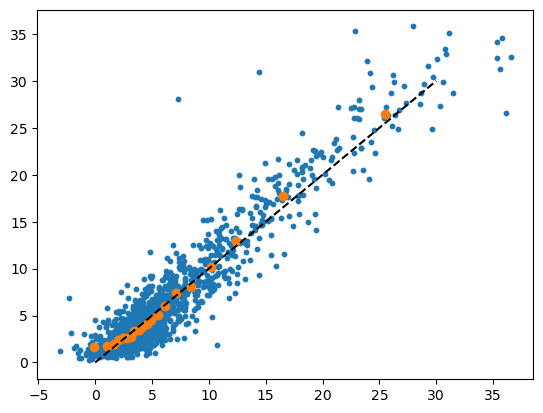

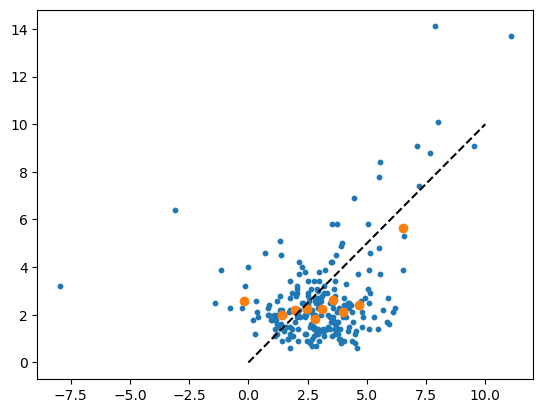

In [23]:
y_pred = all_rdg_lrs.loc[all_rdg_lrs["temp"] <= 30, 'y_pred_rdg']
y_true = all_rdg_lrs.loc[all_rdg_lrs["temp"] <= 30, 'no2_ref']

cut = pd.qcut(y_pred, 20)
plt.scatter(y_pred, y_true, s=10)
plt.scatter(y_pred.groupby(cut, observed=False).mean(), y_true.groupby(cut, observed=False).mean())
plt.plot([0, 30], [0, 30], ls='--', c='k')
plt.show()

y_pred = all_rdg_lrs.loc[all_rdg_lrs["temp"] > 30, 'y_pred_rdg']
y_true = all_rdg_lrs.loc[all_rdg_lrs["temp"] > 30, 'no2_ref']

cut = pd.qcut(y_pred, 10)
plt.scatter(y_pred, y_true, s=10)
plt.scatter(y_pred.groupby(cut, observed=False).mean(), y_true.groupby(cut, observed=False).mean())
plt.plot([0, 10], [0, 10], ls='--', c='k')
plt.show()

In [ ]:
np.mean(y_pred)

In [ ]:
np.mean(y_true)